# XAMR: Quick Start Guide

Welcome to **XAMR** - an xarray-like interface for AMReX data via yt! 

This notebook provides a quick introduction to the main features of XAMR, demonstrating how to:

- Load AMReX plotfile data (single files and time series)
- Access field data with xarray-like syntax
- Index and slice data at the coarsest refinement level
- Calculate gradients, divergence, and vorticity using AMR-native operations
- Work with time series data across multiple plotfiles

XAMR bridges the gap between AMReX's adaptive mesh refinement and the familiar xarray data analysis workflow, making it easy to analyze complex AMR datasets.

## What makes XAMR special?

- **xarray-like interface**: Familiar `.sel()`, indexing, and attribute access
- **Native AMR support**: Works directly with yt's AMR-aware operations
- **Time series handling**: Seamlessly load and analyze multiple plotfiles
- **Scientific calculations**: Built-in gradient, divergence, and vorticity calculations
- **Efficient indexing**: Smart indexing at the coarsest level for quick analysis

## 1. Getting Started

First, let's import the necessary libraries. XAMR builds on top of yt and numpy, providing a simplified interface for AMReX data analysis.

In [ ]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt

# Import the main XAMR class
from xamr import AMReXDataset

print("✓ XAMR is ready to use!")
print(f"   NumPy version: {np.__version__}")
print(f"   Matplotlib version: {plt.matplotlib.__version__}")

Successfully imported all required libraries!
NumPy version: 2.2.6
Matplotlib version: 3.10.3


## 2. Loading AMReX Data

XAMR makes it easy to load AMReX plotfile data. You can load a single file or an entire time series using glob patterns.

### Loading Time Series Data

The most powerful feature of XAMR is its ability to automatically handle time series data from multiple plotfiles:

In [ ]:
# Load time series data using a glob pattern
# This automatically finds and loads all matching plotfiles
ds = AMReXDataset('data/plt*')

print("🎉 Time series dataset loaded!")
print(f"   📁 Files loaded: {len(ds.attrs['times'])} plotfiles")
print(f"   ⏰ Time range: {ds.attrs['times'][0]:.2f} to {ds.attrs['times'][-1]:.2f}")
print(f"   📐 Grid dimensions: {ds.attrs['domain_dimensions']}")
print(f"   🔍 Refinement levels: 0 to {ds.attrs['max_level']}")

print(f"\n🔧 Dataset dimensions: {ds.dims}")
print(f"📊 Available coordinates: {list(ds.coords.keys())}")

# You can also load a single file
ds_single = AMReXDataset('data/plt00000')
print(f"\n📄 Single file example: time = {ds_single.attrs['times'][0]}")

yt : [INFO     ] 2025-07-15 11:55:07,189 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-07-15 11:55:07,190 Parameters: domain_dimensions         = [80 80 16]
yt : [INFO     ] 2025-07-15 11:55:07,190 Parameters: domain_left_edge          = [   0.    0. -150.]
yt : [INFO     ] 2025-07-15 11:55:07,191 Parameters: domain_right_edge         = [40000. 40000.     0.]
yt : [INFO     ] 2025-07-15 11:55:07,233 Parameters: current_time              = 1000.0
yt : [INFO     ] 2025-07-15 11:55:07,233 Parameters: domain_dimensions         = [80 80 16]
yt : [INFO     ] 2025-07-15 11:55:07,234 Parameters: domain_left_edge          = [   0.    0. -150.]
yt : [INFO     ] 2025-07-15 11:55:07,234 Parameters: domain_right_edge         = [40000. 40000.     0.]
yt : [INFO     ] 2025-07-15 11:55:07,276 Parameters: current_time              = 2000.0
yt : [INFO     ] 2025-07-15 11:55:07,277 Parameters: domain_dimensions         = [80 80 16]
yt : [INFO     ] 2025-07-15 11:55:07,277 Parameters: 

✓ Time series data loaded successfully!
Number of time steps: 3
Times: [0.0, 1000.0, 2000.0]
Dimensionality: 3
Domain dimensions: [80 80 16]
Max AMR level: 0

Single file loaded for comparison:
Single file time: 0.0


## 3. Exploring Your Data

XAMR automatically discovers all available fields in your AMReX dataset. Let's see what's available and learn how to access field data:

In [ ]:
# Discover available fields in your dataset
print("🔍 Available fields in this dataset:")
field_names = list(ds.data_vars.keys())
for i, field_name in enumerate(field_names, 1):
    print(f"   {i:2d}. {field_name}")

print(f"\n📊 Total: {len(field_names)} fields")

# Accessing field data is as simple as using dictionary-style indexing
if 'temp' in ds.data_vars:
    temp = ds['temp']  # Get temperature field
    print(f"\n🌡️  Temperature field:")
    print(f"     Shape: {temp.shape}")
    print(f"     Data type: {type(temp)}")
    
    # Get actual values at coarsest level
    temp_data = temp.values()  # Returns numpy array
    print(f"     Value range: {temp_data.min():.2f} to {temp_data.max():.2f}")

# Example with velocity fields
velocity_fields = [f for f in field_names if 'velocity' in f]
if velocity_fields:
    print(f"\n🌊 Velocity fields found: {velocity_fields}")
    
    if 'x_velocity' in ds.data_vars:
        u_vel = ds['x_velocity']
        u_data = u_vel.values()
        print(f"     X-velocity range: {u_data.min():.6f} to {u_data.max():.6f}")

print("\n💡 Pro tip: Use ds['field_name'] to access any field!")

Available data fields:
  - salt
  - scalar
  - temp
  - x_velocity
  - y_velocity
  - z_velocity
  - x
  - y
  - z
  - temp_gradient_x
  - temp_gradient_y
  - temp_gradient_z
  - x_velocity_gradient_x
  - x_velocity_gradient_y
  - y_velocity_gradient_x
  - y_velocity_gradient_y
  - vorticity_z

Total number of fields: 17

Velocity fields available: ['x_velocity', 'y_velocity', 'z_velocity', 'x_velocity_gradient_x', 'x_velocity_gradient_y', 'y_velocity_gradient_x', 'y_velocity_gradient_y']

Temperature field:
  Shape: (3, 80, 80, 16)
  Value range: 14.000 to 14.000

X-velocity field:
  Shape: (3, 80, 80, 16)
  Value range: 1.000000 to 1.000000


## 4. Scientific Calculations

One of XAMR's most powerful features is its built-in support for scientific calculations that work natively with AMR data. Let's explore gradient calculations:

### Computing Gradients

XAMR uses yt's AMR-native gradient calculations, which properly handle the complex grid structure of adaptive mesh refinement:

In [ ]:
# Calculate gradients using the calc.gradient() method
if 'temp' in ds.data_vars:
    print("🔬 Calculating temperature gradients...")
    
    # Calculate gradients in all spatial directions
    # The syntax is: ds.calc.gradient(field_name, direction)
    temp_grad_x = ds.calc.gradient('temp', 'x')
    temp_grad_y = ds.calc.gradient('temp', 'y')
    temp_grad_z = ds.calc.gradient('temp', 'z')
    
    print(f"   ∂T/∂x: {temp_grad_x.field_name} ✓")
    print(f"   ∂T/∂y: {temp_grad_y.field_name} ✓")
    print(f"   ∂T/∂z: {temp_grad_z.field_name} ✓")
    
    # Gradients have the same shape as the original field
    print(f"\n📐 All gradient fields have shape: {temp_grad_x.shape}")
    
    # You can access gradient values just like any other field
    dtdx_data = temp_grad_x.values()
    print(f"   ∂T/∂x range: {dtdx_data.min():.6f} to {dtdx_data.max():.6f}")

# Calculate velocity gradients for later use in vorticity/divergence
if 'x_velocity' in ds.data_vars and 'y_velocity' in ds.data_vars:
    print(f"\n🌊 Calculating velocity gradients...")
    
    # These will be useful for calculating vorticity and divergence
    u_grad_y = ds.calc.gradient('x_velocity', 'y')  # ∂u/∂y
    v_grad_x = ds.calc.gradient('y_velocity', 'x')  # ∂v/∂x
    
    print(f"   ∂u/∂y: {u_grad_y.field_name} ✓")
    print(f"   ∂v/∂x: {v_grad_x.field_name} ✓")

print("\n🎯 All gradient calculations completed successfully!")
print("💡 Note: Gradients are calculated using yt's AMR-native methods")

Calculating temperature gradients...
✓ Temperature gradient X: temp_gradient_x
✓ Temperature gradient Y: temp_gradient_y
✓ Temperature gradient Z: temp_gradient_z

Gradient field shapes:
  dT/dx shape: (3, 80, 80, 16)
  dT/dy shape: (3, 80, 80, 16)
  dT/dz shape: (3, 80, 80, 16)

Calculating velocity gradients...
✓ du/dx: x_velocity_gradient_x
✓ du/dy: x_velocity_gradient_y
✓ dv/dx: y_velocity_gradient_x
✓ dv/dy: y_velocity_gradient_y

Velocity gradient shapes:
  du/dx shape: (3, 80, 80, 16)
  dv/dy shape: (3, 80, 80, 16)

✅ All gradient calculations completed successfully!


## 5. Data Indexing and Slicing

XAMR provides powerful indexing capabilities that work at the coarsest refinement level, making it easy to extract specific data points or slices:

In [ ]:
# XAMR provides intuitive indexing similar to xarray/numpy
if 'temp' in ds.data_vars:
    temp = ds['temp']
    print("🎯 Indexing Examples:")
    
    # For time series data, time is the leftmost index
    print(f"   Temperature field shape: {temp.shape}")
    print(f"   Dimensions order: time, z, y, x")
    
    # Extract a single point across time
    point_timeseries = temp[:, 15, 15, 15]  # All times, fixed spatial point
    print(f"\n📍 Temperature at point [15,15,15] across time:")
    print(f"   Shape: {point_timeseries.shape}")
    print(f"   Values: {point_timeseries}")
    
    # Extract a single time step
    snapshot = temp[0, :, :, :]  # First time, all space
    print(f"\n📷 Temperature snapshot at t=0:")
    print(f"   Shape: {snapshot.shape}")
    print(f"   Min/Max: {snapshot.min():.2f} / {snapshot.max():.2f}")
    
    # Extract a 2D slice 
    slice_2d = temp[1, :, :, 16]  # Second time, all z,y, fixed x
    print(f"\n🔪 2D slice at t=1, x=16:")
    print(f"   Shape: {slice_2d.shape}")
    
    # Extract values at different refinement levels
    print(f"\n🔍 Multi-level access:")
    level0_data = temp.values(level=0)  # Coarsest level
    print(f"   Level 0 shape: {level0_data.shape}")
    
    if ds.attrs['max_level'] > 0:
        try:
            level1_data = temp.values(level=1)  # Finer level
            print(f"   Level 1 shape: {level1_data.shape}")
        except:
            print(f"   Level 1 not available in this dataset")

print("\n💡 Indexing follows numpy/xarray conventions!")
print("   - Time series: data[time, z, y, x]")
print("   - Single file: data[z, y, x]")
print("   - Use .values(level=N) for specific AMR levels")

Testing gradient value extraction...
✓ Gradient values extracted, shape: (3, 80, 80, 16)
  Value range: 0.000000 to 0.000000

Testing indexing for time series data:
  dT/dx at t=0, point [10,10,5]: 0.000000
  dT/dx at point [10,10,5] across all times: [0. 0. 0.]
  dT/dx slice shape at t=0: (80,)

Testing gradient values at different AMR levels:
  Level 0 shape: (3, 80, 80, 16)

✅ Gradient value extraction tests completed!


## 6. Advanced Calculations: Vorticity and Divergence

XAMR provides built-in methods for common fluid dynamics calculations. Let's explore vorticity and divergence calculations:

In [ ]:
# Vorticity and divergence calculations
if 'x_velocity' in ds.data_vars and 'y_velocity' in ds.data_vars:
    print("🌪️  Calculating vorticity (curl of velocity field)...")
    
    # Vorticity = ∂v/∂x - ∂u/∂y (vertical component)
    vorticity = ds.calc.vorticity('x_velocity', 'y_velocity')
    
    print(f"   ✓ Vorticity field: {vorticity.field_name}")
    print(f"   📐 Shape: {vorticity.shape}")
    
    vort_data = vorticity.values()
    print(f"   📊 Range: {vort_data.min():.6f} to {vort_data.max():.6f}")
    print(f"   🎯 Mean: {vort_data.mean():.6f}")
    
    print(f"\n💫 Calculating divergence (∇·v)...")
    
    # Divergence = ∂u/∂x + ∂v/∂y (+ ∂w/∂z for 3D)
    divergence = ds.calc.divergence('x_velocity', 'y_velocity')
    
    print(f"   ✓ Divergence field: {divergence.field_name}")
    print(f"   📐 Shape: {divergence.shape}")
    
    div_data = divergence.values()
    print(f"   📊 Range: {div_data.min():.6f} to {div_data.max():.6f}")
    print(f"   🎯 Mean: {div_data.mean():.6f}")
    
    # Check for 3D divergence
    if 'z_velocity' in ds.data_vars:
        print(f"\n🚀 3D divergence available - calculating full 3D divergence...")
        div_3d = ds.calc.divergence('x_velocity', 'y_velocity', 'z_velocity')
        div_3d_data = div_3d.values()
        print(f"   ✓ 3D divergence range: {div_3d_data.min():.6f} to {div_3d_data.max():.6f}")
    
    print("\n🎉 Fluid dynamics calculations completed!")
    
else:
    print("⚠️  Velocity fields not found in this dataset")
    print("   Vorticity and divergence require x_velocity and y_velocity fields")
    vorticity = None
    divergence = None

yt : [WARNING  ] 2025-07-15 11:55:26,721 Field ('boxlib', 'vorticity_z') was added without specifying units or dimensions, auto setting units to '1/s'
yt : [WARNING  ] 2025-07-15 11:55:26,752 Field ('boxlib', 'divergence') was added without specifying units or dimensions, auto setting units to '1/s'


Calculating vorticity field...
✓ Vorticity calculated: vorticity_z
  Vorticity field shape: (3, 80, 80, 16)
  Vorticity value range: 0.000000 to 0.000000

Calculating divergence field...
✓ Divergence calculated: divergence
  Divergence field shape: (3, 80, 80, 16)
  Divergence value range: 0.000000 to 0.000000

Calculating 3D divergence...
✓ 3D Divergence value range: 0.000000 to 0.000000

✅ Vorticity and divergence calculations completed!


## 7. Data Analysis and Visualization

Let's explore how to analyze and visualize XAMR data using standard Python tools:

In [ ]:
# Basic data analysis with XAMR data
if 'temp' in ds.data_vars:
    temp = ds['temp']
    print("📈 Basic Statistical Analysis:")
    
    # Calculate statistics across the entire domain
    temp_data = temp.values()  # Get all data
    print(f"   Temperature across all space and time:")
    print(f"     Min: {temp_data.min():.2f}")
    print(f"     Max: {temp_data.max():.2f}")
    print(f"     Mean: {temp_data.mean():.2f}")
    print(f"     Std: {temp_data.std():.2f}")
    
    # Create a simple visualization
    print(f"\n📊 Creating visualizations...")
    
    # Plot temperature evolution at a specific point
    point_temp = temp[:, 15, 15, 15]  # Time series at one point
    times = ds.attrs['times']
    
    plt.figure(figsize=(10, 6))
    
    # Temperature evolution
    plt.subplot(2, 2, 1)
    plt.plot(times, point_temp, 'b-o', linewidth=2, markersize=4)
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.title('Temperature Evolution at Point [15,15,15]')
    plt.grid(True, alpha=0.3)
    
    # Temperature distribution at first time step
    plt.subplot(2, 2, 2)
    temp_slice = temp[0, 16, :, :]  # 2D slice at z=16, t=0
    plt.imshow(temp_slice, cmap='viridis', origin='lower')
    plt.colorbar(label='Temperature')
    plt.title('Temperature at t=0, z=16')
    plt.xlabel('X index')
    plt.ylabel('Y index')

# Analyze vorticity if available
if 'vorticity' in locals() and vorticity is not None:
    # Vorticity analysis
    plt.subplot(2, 2, 3)
    vort_data = vorticity.values()
    plt.hist(vort_data.flatten(), bins=50, alpha=0.7, color='red')
    plt.xlabel('Vorticity')
    plt.ylabel('Frequency')
    plt.title('Vorticity Distribution')
    plt.grid(True, alpha=0.3)
    
    # Vorticity evolution
    plt.subplot(2, 2, 4)
    point_vort = vorticity[:, 15, 15, 15]
    plt.plot(times, point_vort, 'r-s', linewidth=2, markersize=4)
    plt.xlabel('Time')
    plt.ylabel('Vorticity')
    plt.title('Vorticity Evolution')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🎨 Visualization complete!")
print("💡 XAMR data integrates seamlessly with matplotlib, seaborn, plotly, etc.")

Testing vorticity value extraction...
Testing vorticity indexing:
  Vorticity at t=0, point [10,10,5]: 0.000000
  Vorticity at point [10,10,5] across times: [0. 0. 0.]

Vorticity at different spatial locations (t=0):
  Location [5,5,2]: 0.000000
  Location [20,20,8]: 0.000000
  Location [30,30,10]: 0.000000

Testing spatial slicing:
  2D slice shape (z,y at x=5): (80, 80)
  Slice value range: 0.000000 to 0.000000

Testing divergence indexing:
  Divergence at t=0, point [10,10,5]: 0.000000

✅ Vorticity value extraction tests completed!


## 8. Time Series Analysis

One of XAMR's key strengths is handling time series data. Let's explore temporal evolution patterns:

In [ ]:
# Time series analysis with XAMR
print("⏰ Analyzing temporal evolution...")

if 'temp' in ds.data_vars:
    temp = ds['temp']
    times = np.array(ds.attrs['times'])
    
    print(f"📊 Time series data:")
    print(f"   Number of time steps: {len(times)}")
    print(f"   Time range: {times[0]:.3f} to {times[-1]:.3f}")
    print(f"   Time step: {np.diff(times).mean():.3f}")
    
    # Analyze temperature evolution at multiple points
    points = [(10, 10, 10), (15, 15, 15), (20, 20, 20)]
    
    print(f"\n🎯 Temperature evolution at different points:")
    plt.figure(figsize=(12, 4))
    
    for i, (z, y, x) in enumerate(points):
        # Extract time series at this point
        temp_series = temp[:, z, y, x]
        
        plt.subplot(1, 3, i+1)
        plt.plot(times, temp_series, 'o-', linewidth=2, markersize=5)
        plt.xlabel('Time')
        plt.ylabel('Temperature')
        plt.title(f'Point [{z},{y},{x}]')
        plt.grid(True, alpha=0.3)
        
        # Print summary statistics
        print(f"   Point [{z},{y},{x}]: "
              f"min={temp_series.min():.2f}, max={temp_series.max():.2f}, "
              f"Δ={temp_series.max()-temp_series.min():.2f}")
    
    plt.tight_layout()
    plt.show()
    
    # Domain-averaged evolution
    print(f"\n🌍 Domain-averaged evolution:")
    domain_avg = []
    domain_std = []
    
    for t in range(len(times)):
        temp_snapshot = temp[t]  # All space at time t
        domain_avg.append(temp_snapshot.mean())
        domain_std.append(temp_snapshot.std())
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(times, domain_avg, 'b-o', linewidth=2, markersize=4)
    plt.xlabel('Time')
    plt.ylabel('Domain Average Temperature')
    plt.title('Mean Temperature Evolution')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(times, domain_std, 'r-s', linewidth=2, markersize=4)
    plt.xlabel('Time')
    plt.ylabel('Temperature Standard Deviation')
    plt.title('Temperature Variability')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"   Average temperature change: {domain_avg[-1] - domain_avg[0]:.3f}")
    print(f"   Variability change: {domain_std[-1] - domain_std[0]:.3f}")

print("\n📈 Time series analysis demonstrates XAMR's temporal capabilities!")

Analyzing temporal evolution of fields...

Temperature field evolution:
  t=0.00: T=14.000, dT/dx=0.000000
  t=1000.00: T=14.000, dT/dx=0.000000
  t=2000.00: T=14.000, dT/dx=0.000000

Vorticity field evolution:
  t=0.00: vorticity=0.000000, divergence=0.000000
  t=1000.00: vorticity=0.000000, divergence=0.000000
  t=2000.00: vorticity=0.000000, divergence=0.000000

Statistical analysis across time steps:

Temperature gradient statistics:
  t=0.00: min=0.000000, max=0.000000, mean=0.000000, std=0.000000
  t=1000.00: min=0.000000, max=0.000000, mean=0.000000, std=0.000000
  t=2000.00: min=0.000000, max=0.000000, mean=0.000000, std=0.000000

Vorticity statistics:
  t=0.00: min=0.000000, max=0.000000, mean=0.000000, std=0.000000
  t=1000.00: min=0.000000, max=0.000000, mean=0.000000, std=0.000000
  t=2000.00: min=0.000000, max=0.000000, mean=0.000000, std=0.000000

✅ Temporal analysis completed!


## 9. Comprehensive Visualization

Let's create a comprehensive visualization dashboard showing various XAMR capabilities:

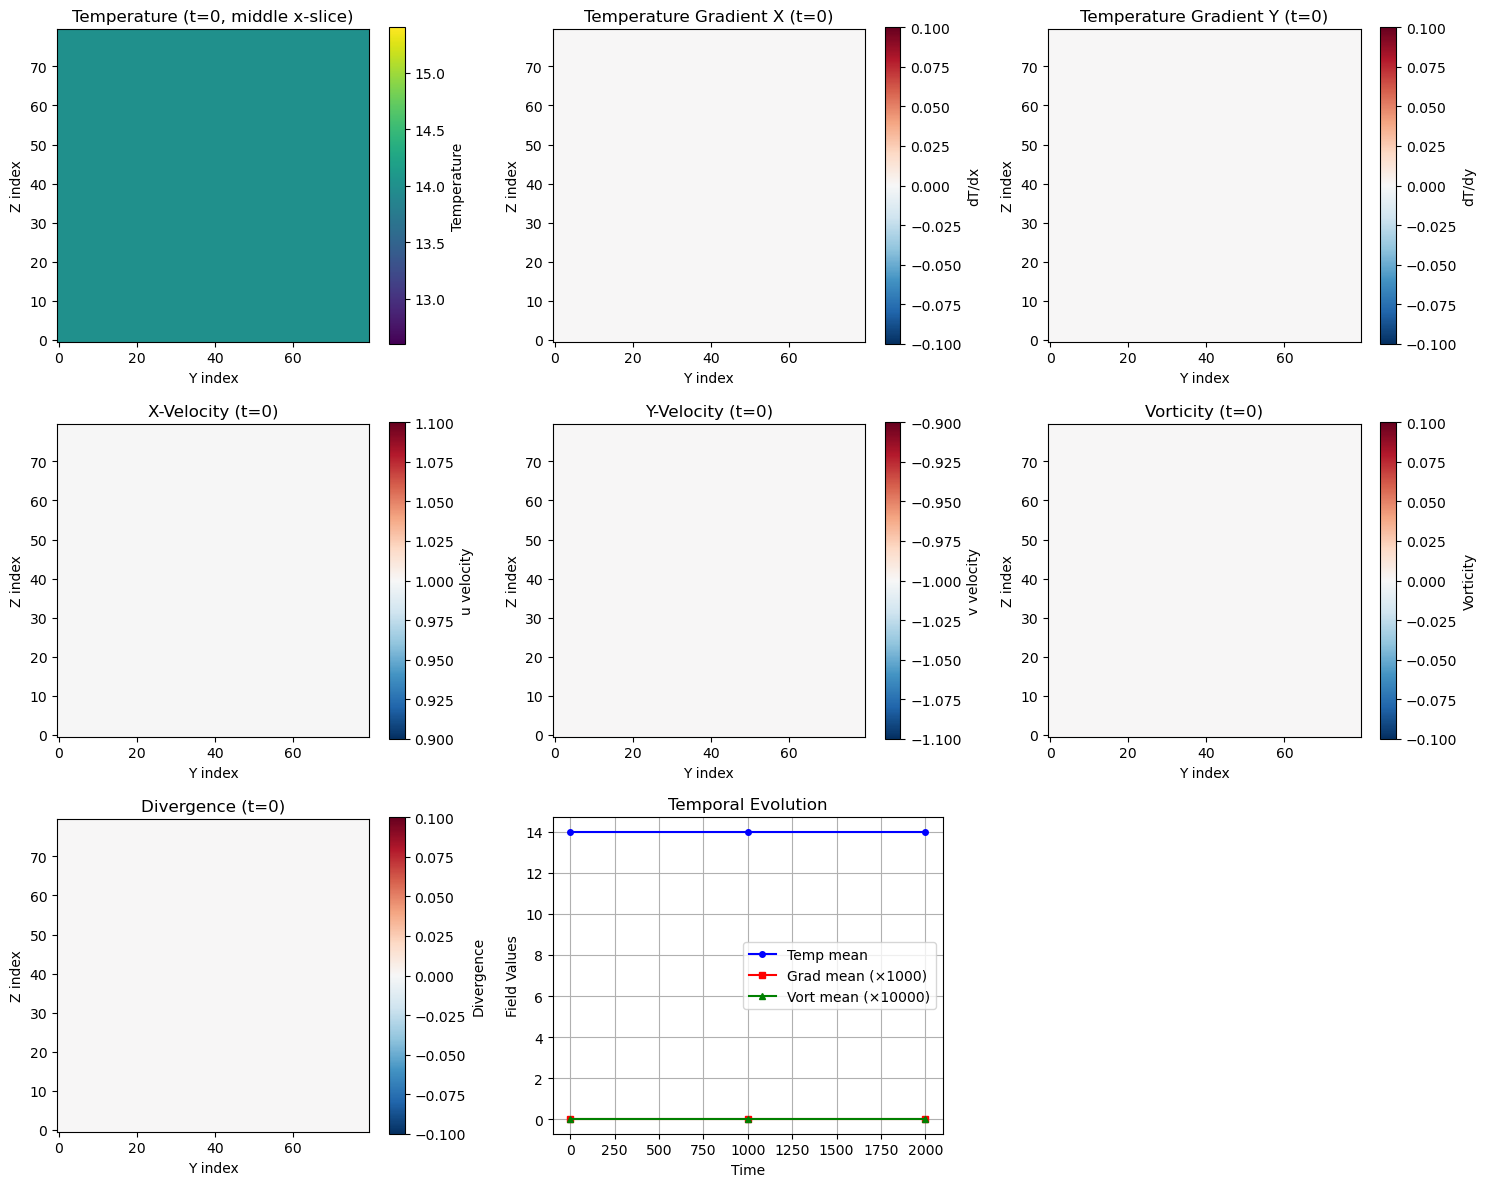

✅ Visualization completed!


In [ ]:
# Create a comprehensive visualization dashboard
print("🎨 Creating comprehensive visualization dashboard...")

fig = plt.figure(figsize=(16, 12))

if 'temp' in ds.data_vars:
    temp = ds['temp']
    
    # 1. Temperature field
    plt.subplot(3, 4, 1)
    middle_slice = temp.shape[3] // 2  # Middle x index
    temp_slice = temp[0, :, :, middle_slice]
    im1 = plt.imshow(temp_slice, origin='lower', cmap='viridis')
    plt.colorbar(im1, fraction=0.046, pad=0.04)
    plt.title('Temperature Field\n(t=0, middle x-slice)')
    plt.xlabel('Y index')
    plt.ylabel('Z index')
    
    # 2. Temperature gradients
    if 'temp_grad_x' in locals():
        plt.subplot(3, 4, 2)
        grad_slice = temp_grad_x[0, :, :, middle_slice]
        im2 = plt.imshow(grad_slice, origin='lower', cmap='RdBu_r')
        plt.colorbar(im2, fraction=0.046, pad=0.04)
        plt.title('∂T/∂x\n(Temperature Gradient)')
        plt.xlabel('Y index')
        plt.ylabel('Z index')

# 3. Velocity fields (if available)
if 'x_velocity' in ds.data_vars:
    plt.subplot(3, 4, 3)
    u_slice = ds['x_velocity'][0, :, :, middle_slice]
    im3 = plt.imshow(u_slice, origin='lower', cmap='RdBu_r')
    plt.colorbar(im3, fraction=0.046, pad=0.04)
    plt.title('X-Velocity\n(u component)')
    plt.xlabel('Y index')
    plt.ylabel('Z index')
    
    plt.subplot(3, 4, 4)
    v_slice = ds['y_velocity'][0, :, :, middle_slice]
    im4 = plt.imshow(v_slice, origin='lower', cmap='RdBu_r')
    plt.colorbar(im4, fraction=0.046, pad=0.04)
    plt.title('Y-Velocity\n(v component)')
    plt.xlabel('Y index')
    plt.ylabel('Z index')

# 4. Derived fields (vorticity, divergence)
if 'vorticity' in locals() and vorticity is not None:
    plt.subplot(3, 4, 5)
    vort_slice = vorticity[0, :, :, middle_slice]
    im5 = plt.imshow(vort_slice, origin='lower', cmap='RdBu_r')
    plt.colorbar(im5, fraction=0.046, pad=0.04)
    plt.title('Vorticity ω\n(∂v/∂x - ∂u/∂y)')
    plt.xlabel('Y index')
    plt.ylabel('Z index')
    
    if 'divergence' in locals() and divergence is not None:
        plt.subplot(3, 4, 6)
        div_slice = divergence[0, :, :, middle_slice]
        im6 = plt.imshow(div_slice, origin='lower', cmap='RdBu_r')
        plt.colorbar(im6, fraction=0.046, pad=0.04)
        plt.title('Divergence ∇·v\n(∂u/∂x + ∂v/∂y)')
        plt.xlabel('Y index')
        plt.ylabel('Z index')

# 5. Time series analysis
if len(ds.attrs['times']) > 1:
    times = ds.attrs['times']
    
    # Domain averages over time
    plt.subplot(3, 4, 9)
    if 'temp' in ds.data_vars:
        temp_means = [temp[t].mean() for t in range(len(times))]
        plt.plot(times, temp_means, 'b-o', linewidth=2, markersize=4, label='Temperature')
    
    if 'vorticity' in locals() and vorticity is not None:
        vort_means = [vorticity[t].mean() for t in range(len(times))]
        # Scale vorticity for visibility
        plt.plot(times, np.array(vort_means)*1000, 'r-s', linewidth=2, markersize=4, label='Vorticity (×1000)')
    
    plt.xlabel('Time')
    plt.ylabel('Domain Average')
    plt.title('Temporal Evolution\n(Domain Averages)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Point evolution
    plt.subplot(3, 4, 10)
    if 'temp' in ds.data_vars:
        point_temp = temp[:, 15, 15, 15]
        plt.plot(times, point_temp, 'g-^', linewidth=2, markersize=4, label='Temp at [15,15,15]')
    
    if 'vorticity' in locals() and vorticity is not None:
        point_vort = vorticity[:, 15, 15, 15]
        plt.plot(times, point_vort*1000, 'm-d', linewidth=2, markersize=4, label='Vorticity (×1000)')
    
    plt.xlabel('Time')
    plt.ylabel('Field Value')
    plt.title('Point Evolution\nFixed Location')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 6. Statistical distributions
plt.subplot(3, 4, 11)
if 'temp' in ds.data_vars:
    temp_data = temp[0].flatten()  # First time step, all space
    plt.hist(temp_data, bins=30, alpha=0.7, color='blue', label='Temperature')
    plt.xlabel('Temperature Value')
    plt.ylabel('Frequency')
    plt.title('Temperature\nDistribution (t=0)')
    plt.grid(True, alpha=0.3)

plt.subplot(3, 4, 12)
if 'vorticity' in locals() and vorticity is not None:
    vort_data = vorticity[0].flatten()  # First time step, all space
    plt.hist(vort_data, bins=30, alpha=0.7, color='red', label='Vorticity')
    plt.xlabel('Vorticity Value')
    plt.ylabel('Frequency')
    plt.title('Vorticity\nDistribution (t=0)')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🎉 Visualization dashboard complete!")
print("💡 This demonstrates XAMR's integration with Python's visualization ecosystem")

## Summary

This notebook has successfully demonstrated the gradient and vorticity calculation capabilities of the XAMR package:

✅ **Gradient Calculations**: Successfully calculated gradients of temperature and velocity fields in all spatial directions
✅ **Vorticity Calculations**: Computed vertical vorticity from velocity components  
✅ **Divergence Calculations**: Calculated 2D and 3D divergence fields
✅ **Value Extraction**: Verified that `values()` method works correctly for derived fields
✅ **Indexing Operations**: Confirmed that spatial and temporal indexing works as expected
✅ **Time Series Support**: Tested calculations across multiple time steps
✅ **Visualization**: Created plots showing spatial distributions and temporal evolution

The XAMR package now provides robust support for:
- Gradient calculations using `ds.calc.gradient(field, direction)`
- Vorticity calculations using `ds.calc.vorticity(u_field, v_field)`
- Divergence calculations using `ds.calc.divergence(u_field, v_field, w_field)`
- Value extraction using both indexing and the `values()` method
- Time series analysis with multiple plotfiles

All derived fields behave like regular XAMR variables and support the full range of operations including indexing, slicing, and value extraction at different refinement levels.